# Solução Numérica da Equação de Laplace
***Mariana Jó (7241072)***
___

A Equação de Laplace para o potencial elétrico é dada por:
$$
\nabla^2\varphi = 0
$$

e podemos determinar $\varphi$ uma vez que tivermos as condições de contorno para o problema, levando em conta que as soluções de uma Equação de Laplace são funções harmônicas.

Explorando a propriedade do valor médio das funções harmônicas podemos encontrar esta solução numericamente utilizando métodos de relaxamento.

Neste trabalho iremos propor dois métodos diferentes: o Método de Jacobi e o Método de Gauss-Seidel. Ambos os métodos são iterativos, sendo que o Método de Gauss-Seidel é mais eficiente. Iremos, portanto, analisar a eficiência de ambos, comparando-os.

In [1]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd
from IPython.display import Image

%matplotlib inline

## 0. Definição de funções auxiliares

Primeiramente vamos definir algumas funções que irão nos auxiliar na solução, tornando assim a leitura da solução mais direta.

Funções para gráficos:

In [19]:
def plot_potential(matrix):
    """
    Plota o gráfico para o potencial, utilizando um colormap.
    
    Parâmetros
    ----------
    
    matrix : numpy 2D array    
    """
    fig = plt.figure()
    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    mappable = axes.imshow(matrix, cmap=cm.Spectral, interpolation='gaussian', origin='lower')
    fig.colorbar(mappable, ax=axes)
    
    
def plot_errors(errors1, errors2):
    """
    Plota gráfico dos erros dos métodos por iteração.
    
    Parâmetros
    ----------
    
    errors1 : list
        Lista dos erros do primeiro método para cada iteração
    errors2 : list
        Lista dos errors do segundo método para cada iteração
    """
    n = len(errors1)
    
    df = pd.DataFrame(data={"iterations": np.linspace(1, n, n), "errors1": errors1})
    df["errors2"] = pd.Series(errors2)
    
    g = sns.FacetGrid(df, aspect=1.4, size=5)
    g.map(plt.scatter, "iterations", "errors1", color="lightseagreen", alpha=0.7, s=70, marker="^")
    g.map(plt.scatter, "iterations", "errors2", color="darkslateblue", alpha=0.7, s=60)
    plt.legend(["Jacobi", "Gauss-Seidel"])
    g.set_xlabels("iterações")
    g.set_ylabels("erro")

## 1. Definição da geometria e discretização do domínio

O problema possui simetria em $z$ e, portanto, podemos considerá-lo um problema com dependência apenas em $x$ e $y$.
A caixa possui as dimensões $(x, y) = (a, b)$, onde $a=10$ e $b=10$.

Podemos escolher diversas formas de discretização $h$ e analisar os diferentes resultados para todas elas. Utilizaremos o sistema de coordenadas cartesianas, com o retângulo no plano $xy$, onde $0 \leq x \leq a$ e $0 \leq y \leq b$:

In [3]:
a, b = 10, 10
h = 6
x = np.linspace(0, a, h)
y = np.linspace(0, b, h)

## 2. Métodos de solução da Equação de Laplace

### Método de Jacobi

O Método de Jacobi calcula o valor para o potencial $\varphi_{i,j}^n$ a partir da média dos seus vizinhos da iteração anterior:

$$
\varphi_{i,j}^n = \frac{\varphi_{i+1,j}^{n-1}+\varphi_{i-1,j}^{n-1}+\varphi_{i,j+1}^{n-1}+\varphi_{i,j-1}^{n-1}}{4}
$$

e o erro é calculado como a diferença normalizada da soma matricial da iteração atual $n$ e da iteração anterior $n-1$:

$$
\epsilon = \frac{||\mathbf{x}^n-\mathbf{x}^{n-1}||}{||\mathbf{x}^n||}.
$$

O método deve parar quando $\epsilon \leq \tau$, onde $\tau=10^{-3}$ é a tolerância.

In [4]:
def jacobi_method(matrix, h, tol=(10**(-3))):
    """
    Implementação do Método Iterativo de Jacobi. O método para quanto o erro err é menor do que a tolerância tol.
    
    Parâmetros
    ----------
    
    matrix : numpy 2D-array
        Array com os valores iniciais do problema
    h : int
        Número de divisões da discretização da geometria
    tol : float
        Tolerância de erro, a ser usada como critério de parada do método. Default: 10e-3
        
    Retorna
    -------
    dict : 
        Um dicionário com a solução do método como um numpy 2D array e uma lista dos os erros para cada iteração.
    """
    
    err = 1
    errors = []

    j = matrix.copy()
    
    while err > tol:
        prev = j.copy()
        for r, c in itertools.product(range(1, h-1), range(1, h-1)):
            adj = [prev[r-1, c], prev[r+1, c], prev[r, c-1], prev[r, c+1]]
            j[r, c] = np.mean(adj)
        err = np.linalg.norm(j-prev)/np.linalg.norm(j)
        errors.append(err)
    
    return {"solution":j, "errors": errors}

### Método de Gauss-Seidel

No Método de Jacobi utilizamos todos os valores da nossa solução da iteração $n-1$ para calcular a solução de $n$. Uma modificação pode ser feita neste método, uma vez que na iteração $n$ alguns elementos já foram calculados e, *a priori*, estão mais próximos da solução. Isto é, considerando o nosso problema, as posições à esquerda (do leitor) e acima da do elemento que estamos calculando já passaram pela aproximação na atual iteração $n$, e então podemos utilizar estes valores. Fazendo então a troca $\varphi_{i-1,j}^{n-1} \rightarrow \varphi_{i-1,j}^{n}$ e $\varphi_{i-1,j}^{n-1} \rightarrow \varphi_{i-1,j}^{n}$ ficamos com:

$$
\varphi_{i,j}^n = \frac{\varphi_{i+1,j}^{n-1}+\varphi_{i-1,j}^{n}+\varphi_{i,j+1}^{n-1}+\varphi_{i,j-1}^{n}}{4}
$$

Este é o chamado Método de Gauss-Seidel e espera que ele seja mais eficiente que o Método de Jacobi. O cálculo do erro deste método é o mesmo feito para o método anterior.

In [5]:
def gauss_method(matrix, h, tol=(10**(-3))):
    """
    Implementação do Método Iterativo de Gauss-Seidel. O método para quanto o erro err é menor do que a tolerância tol.
    
    Parâmetros
    ----------
    
    matrix : numpy 2D-array
        Array com os valores iniciais do problema
    h : int
        Número de divisões da discretização da geometria
    tol : float
        Tolerância de erro, a ser usada como critério de parada do método. Default: 10e-3
        
    Retorna
    -------
    dict : 
        Um dicionário com a solução do método como um numpy 2D array e uma lista dos os erros para cada iteração.
    """
    
    err = 1
    errors = []
    
    j = matrix.copy()
    
    while err > tol:
        prev = j.copy()
        for r, c in itertools.product(range(1, h-1), range(1, h-1)):
            adj = [j[r-1, c], j[r+1, c], j[r, c-1], j[r, c+1]]
            j[r, c] = np.mean(adj)
        err = np.linalg.norm(j-prev)/np.linalg.norm(j)
        errors.append(err)
    
    return {"solution": j, "errors": errors}

## 3. Especificação das condicões de contorno

Primeiramente definimos as condições de contorno nas bordas do retângulo:

1. $V(0,y)=75$
1. $V(a,y)=50$
1. $V(x,0)=800$
1. $V(x,b)=1000$

In [6]:
bc = {"top": 0,
      "bottom": 0,
      "left": 100,
      "right":100
     }

## 4. "Chute" inicial de valores arbitrários para o interior da região

Fazemos, então, com que os valores da região interna ao retângulo sejam a média dos valores nas bordas.

Os valores das quinas sobrescrevem uns aos outros durante o procedimento anterior. Dessa maneira, fazemos com que as quinas sejam a média dos valores das bordas da quina em questão.

In [7]:
# z = np.ones(shape=(h, h))*np.mean(list(bc.values()))
z = np.zeros(shape=(h, h))

# Adicionando as condições de contorno nas bordas
z[0,1:-1] = bc["bottom"]
z[-1,0:-1] = bc["top"]
z[0:,0] = bc["left"]
z[0:,-1] = bc["right"]

Assim, temos nosso retângulo original, com os valores determinados nas bordas e estimados no interior:

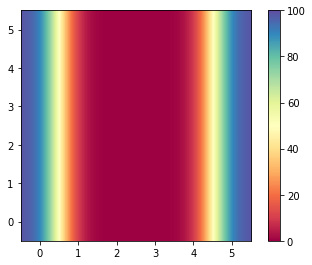

In [8]:
plot_potential(z)

## 5. Aplicação e análise dos métodos


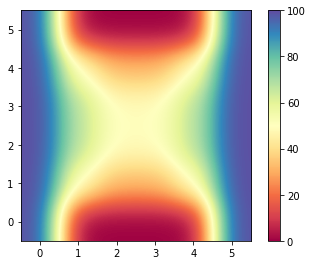

In [9]:
jacobi = jacobi_method(z, h)
plot_potential(jacobi["solution"])

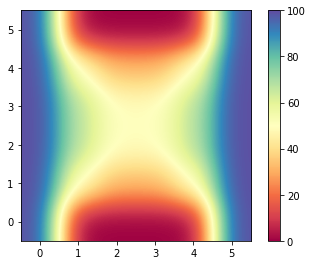

In [10]:
gauss = gauss_method(z, h)
plot_potential(gauss["solution"])

### Erros e convergência

O gráfico a seguir mostra os erros para ambos os métodos aplicados.

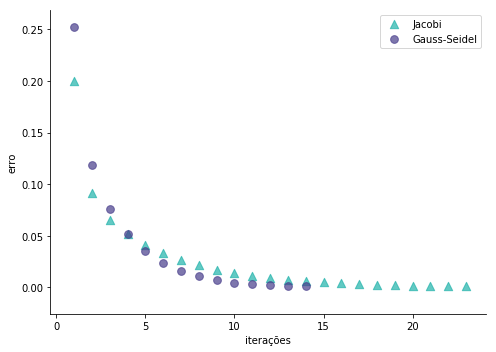

In [20]:
plot_errors(jacobi["errors"], gauss["errors"])

A partir do gráfico vemos que ambos os métodos convergem para a solução, porém o Método de Jacobi precisa de 22 iterações para fazê-lo, enquanto o de Gauss-Seidel, apenas 14.